# Code for CUQIpy paper 2, section 2. Framework for PDE-based Bayesian inverse problems in CUQIpy (sections 2.2 to 2.6)

##  2.2 The discretized heat equation in CUQIpy

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from cuqi.distribution import Gaussian, JointDistribution
from cuqi.geometry import Continuous1D, KLExpansion, StepExpansion
from cuqi.pde import TimeDependentLinearPDE
from cuqi.model import PDEModel
from cuqi.sampler import CWMH
from cuqi.array import CUQIarray
from paper_figures import plot_figure2, plot_figure3, plot_figure4

In [2]:
n_grid = 100   # Number of solution nodes
h = 1/(n_grid+1)   # Space step size

In [3]:
grid = np.linspace(h, 1-h, n_grid)

In [4]:
tau_max = 0.01 # Final time
cfl = 5/11 # The cfl condition to have a stable solution
dt_approx = cfl*h**2 # Defining approximate time step size
n_tau = int(tau_max/dt_approx)+1 # Number of time steps

In [5]:
tau = np.linspace(0, tau_max, n_tau)

In [6]:
c = 1

In [7]:
f = np.zeros(n_grid)
D_c = c**2 * ( np.diag(-2*np.ones(n_grid), 0) +
np.diag(np.ones(n_grid-1), -1) +
np.diag(np.ones(n_grid-1), 1) ) / h**2

In [8]:
def PDE_form(g, tau_current):
    return (D_c, f, g)

In [9]:
PDE = TimeDependentLinearPDE(PDE_form, tau, grid_sol=grid)

In [10]:
print(PDE)

CUQI TimeDependentLinearPDE.
PDE form expression:
def PDE_form(g, tau_current):
    return (D_c, f, g)



In [11]:
g_custom =1/30*(1-np.cos(2*np.pi*(1-grid)/(1)))\
                +1/30*np.exp(-2*(10*(grid-0.5))**2)+\
                 1/30*np.exp(-2*(10*(grid-0.8))**2)

In [12]:
PDE.assemble(g_custom)
u_custom, info = PDE.solve()

In [13]:
y_custom = PDE.observe(u_custom)

Code cell for plotting figure 2:

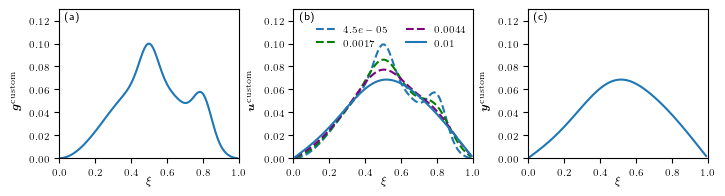

In [14]:
fig_dir = './figs/'
version = 'v3'

intermediate_indices = [1, 39, 99, len(tau)-1] # Indices of the intermediate times
intermediate_times = [tau[i] for i in intermediate_indices]
u_intermediate = u_custom[:, intermediate_indices] # Intermediate solutions

plot_figure2(fig_dir, version,
             g_custom, u_custom, y_custom, u_intermediate,
             grid, tau, intermediate_times)

## 2.3 The 1D heat forward problem in CUQIpy

In [15]:
G_cont = Continuous1D(grid)

In [16]:
A = PDEModel(PDE, range_geometry=G_cont, domain_geometry=G_cont)

## 2.4 Parametrization by the geometry class

The following code cell is to update final time to 0.02

In [17]:
tau_max = 0.02 # Final time
dt_approx = cfl*h**2 # Defining approximate time step size
n_tau = int(tau_max/dt_approx)+1 # Number of time steps
tau = np.linspace(0, tau_max, n_tau)
PDE = TimeDependentLinearPDE(PDE_form, tau, grid_sol=grid)

In [18]:
n_step = 3

In [19]:
G_step = StepExpansion(grid, n_steps=n_step)

In [20]:
x_step = CUQIarray([0, 1, 0.5], geometry=G_step)

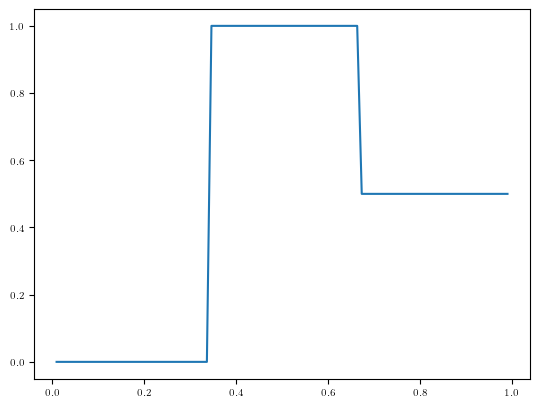

In [21]:
x_step.plot()

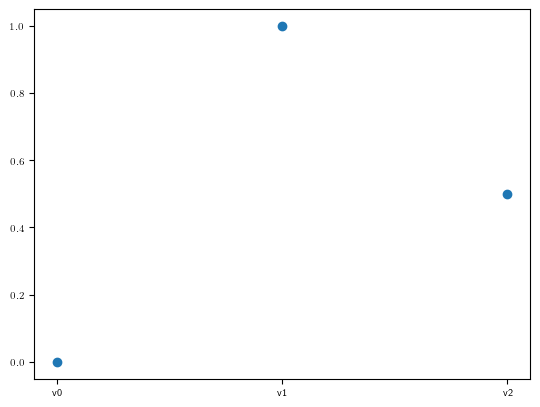

In [22]:
x_step.plot(plot_par=True)

In [23]:
A = PDEModel(PDE, range_geometry=G_cont, domain_geometry=G_step)

In [24]:
print(A)

CUQI PDEModel: StepExpansion(3,) -> Continuous1D(100,).
    Forward parameters: ['x'].
    PDE: TimeDependentLinearPDE.


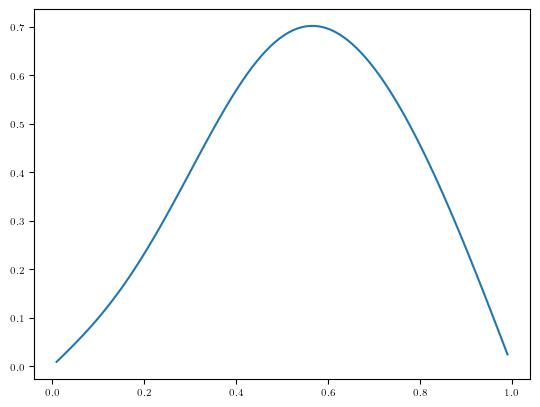

In [25]:
y_step = A(x=x_step)
y_step.plot()

Code cell for plotting figure 3:

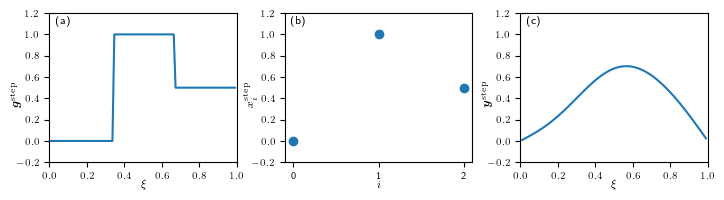

In [26]:
fig_dir = './figs/'
version = 'v3'
plot_figure3(fig_dir, version, x_step, y_step)

## 2.5. Specifying and solving the PDE-based Bayesian inverse problem

In [27]:
# set up the noise level:
noise_level = 0.1
s_noise =1.0/np.sqrt(n_grid)* noise_level*np.linalg.norm(y_step)

In [28]:
x = Gaussian(np.zeros(n_step), 1, geometry=G_step)
y = Gaussian(A(x), s_noise**2, geometry=G_cont)

In [29]:
print(y)

CUQI Gaussian. Conditioning variables ['x'].


In [30]:
prior_samples = x.sample(5)

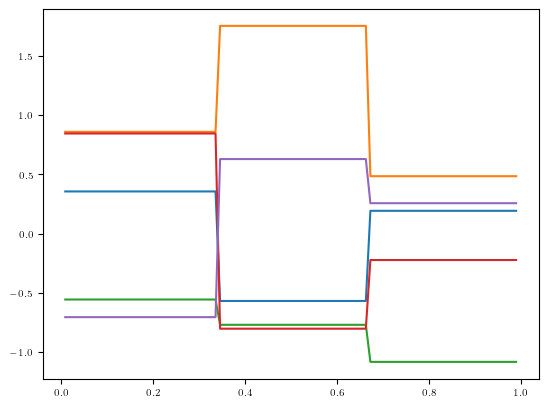

In [31]:
prior_samples.plot()

In [32]:
y_obs = y(x=x_step).sample()

In [33]:
joint = JointDistribution(x, y)
posterior = joint(y=y_obs) # condition on y=y_obs

In [34]:
print(joint)

JointDistribution(
    Equation: 
	p(x,y) = p(x)p(y|x)
    Densities: 
	x ~ CUQI Gaussian.
	y ~ CUQI Gaussian. Conditioning variables ['x'].
)


In [35]:
my_sampler = CWMH(posterior)

In [36]:
posterior_samples = my_sampler.sample_adapt(50000)

Sample 50000 / 50000

Average acceptance rate all components: 0.0481 



## 2.6. Posterior samples analysis, and visualization

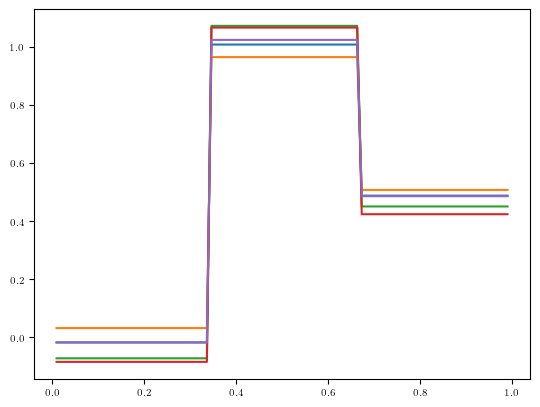

In [37]:
samples_indices = [2000, 3000, 4000, 5000, 6000]
posterior_samples.plot(samples_indices)

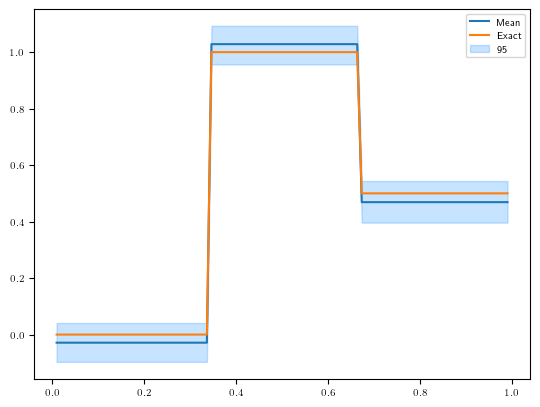

In [38]:
posterior_samples.plot_ci(95, exact=x_step)

Code cell for plotting figure 4:

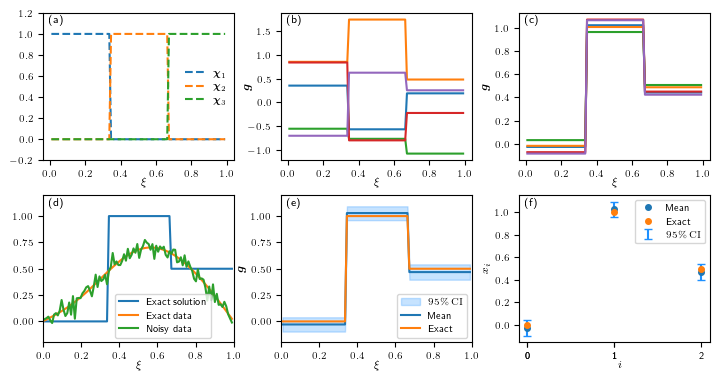

In [53]:
fig_dir = './figs/'
version = 'v6'
plot_figure4(fig_dir, version, G_step, 
                 prior_samples, posterior_samples,
                 x_step, y_step, y_obs)